# Betting on Pi

What do gambling and Pi have to do with one another? Probably a lot of things, but the angle I am aiming for is the relationship between Pi and a city in Monaco. I want to go through how we can use Monte Carlo sampling to predict Pi.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 4})
from tqdm import tqdm

### Geometric Approach

Before we get into the actual analysis, we need to write some code!

In [2]:
class MCPi:
    """
    A class to study Monte Carlo sampling as applied to 
    the computation of Pi.
    
    Attributes
    ----------
    coordinates : np.ndarray
            Coordinates of points plotted.
    n_circle_points : int
            Number of points in the circle
    n_points : int
            Total number of points.
    """
    
    def __init__(self):
        """
        Constructor for the MCPi class.
        """
        self.coordinates : np.ndarray
        self.n_circle_points : int
        self.n_points : int
    
    def plot_image(self, axs = None):
        """
        Plot the circle, square, and points.
        
        Parameters
        ----------
        axs : mpl.axis
                An axis object to plot to if desired.
        """
        circle = plt.Circle((0, 0), 1, fill=False)
        square = patches.Rectangle((0, 0), 1, 1, fill=False)
        if axs is None:
            ax = plt.gca()
        else:
            ax = axs
        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.3, 1.3)
        ax.spines.left.set_position('zero')
        ax.spines.right.set_color('none')
        ax.spines.bottom.set_position('zero')
        ax.spines.top.set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.add_patch(circle)
        ax.add_patch(square)
        plt.show()
        
    def plot_sampling(self, axs = None, show: bool = False):
        """
        Plot the result of the sampling.
        
        Parameters
        ----------
        axs : mpl.axis
                An axis object to plot to if desired.
        """
        circle = plt.Circle((0, 0), 1, fill=False, linewidth=3, edgecolor='k', zorder=10)
        square = patches.Rectangle((0, 0), 1, 1, fill=False, linewidth=3, edgecolor='k', zorder=10)
        if axs is None:
            ax = plt.gca()
        else:
            ax = axs
        ax.set_xlim(-0.0, 1.0)
        ax.set_ylim(-0.0, 1.0)
        ax.spines.left.set_position('zero')
        ax.spines.right.set_color('none')
        ax.spines.bottom.set_position('zero')
        ax.spines.top.set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.plot(self.coordinates[:, 0], self.coordinates[:, 1], '.')
        inner_points = np.array(list(filter(lambda x: np.linalg.norm(x) <= 1, self.coordinates)))
        ax.plot(inner_points[:, 0], inner_points[:, 1], 'r.')
        ax.add_patch(circle)
        ax.add_patch(square)
        ax.set_title(f"N: {self.n_points} ; $\pi$ = {4 * self.n_circle_points / self.n_points}")
        
        if show:
            plt.show()
        
    def _circle_points(self):
        """
        Compute the number of points in the circle.
        """
        radial_values = np.linalg.norm(self.coordinates, axis=1)
        self.n_circle_points = len(list(filter(lambda x: x <= 1, radial_values)))
        
    def sample_points(self, N: int):
        """
        Draw N points from a normal distribution.
        
        N : int
                Number of points to draw.
        """
        self.n_points = N
        self.coordinates = np.random.random(size=(N, 2))
        self._circle_points()  # compute the number of points in the circle.

The first thing we want to do is look at our problem. We draw first the unit circle. In the top quadrant, we also draw a unit square, with an origin at 0. The general idea of Monte Carlo sampling in this approach is to randomly place points inside of this square, and see how the ratio of points which happen to fall within the circle, compare to that of the square. However, to begin, let's just look at the problem first.

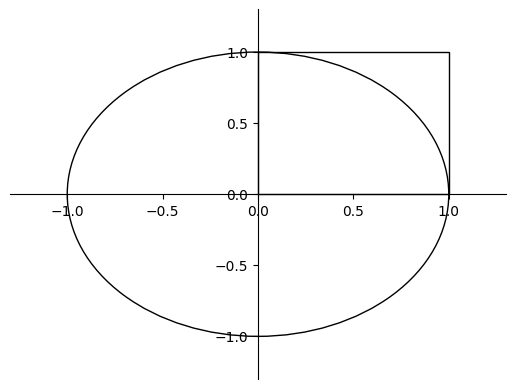

In [3]:
mc_study = MCPi()
mc_study.plot_image()

So we now have ourselves a circle and square in the positive-positive quadrant of a Cartesian axis. Now its time for some math! 

$A_{circle} = \pi\cdot r^{2}$

$A_{square} = l^{2}$

$\frac{\frac{1}{4}A_{circle}}{A_{square}} = \frac{\pi}{4}$

Here the $\frac{1}{4}$ arises from the fact that we only consider the top quarter of the unit circle. So now we have an expression for areas, but this will not directly help with random sampling. But how can we make it better? The first step might be to consider how we can *fill* this area. Imagine randomly placing points into the square. The number of points we can put into the square will be proportional to the area of the square. As the points start to fill up the the whole area we would see that:

$4*\frac{N_{circle}}{N_{square}} = \pi $

where here we are only considering points in the upper quadrant of the unit circle. So let's give it a try!

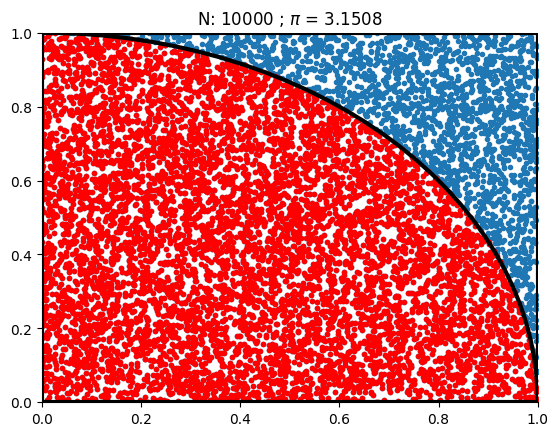

In [4]:
mc_study.sample_points(10000)
mc_study.plot_sampling(show=True)

This looks pretty good! We have a bunch of points in the circle, a bunch of points in both the circle, and the square, and the estimation of Pi is pretty close. Now let's do something a little more interesting, and look at how these predictions evolve with changed sample points.

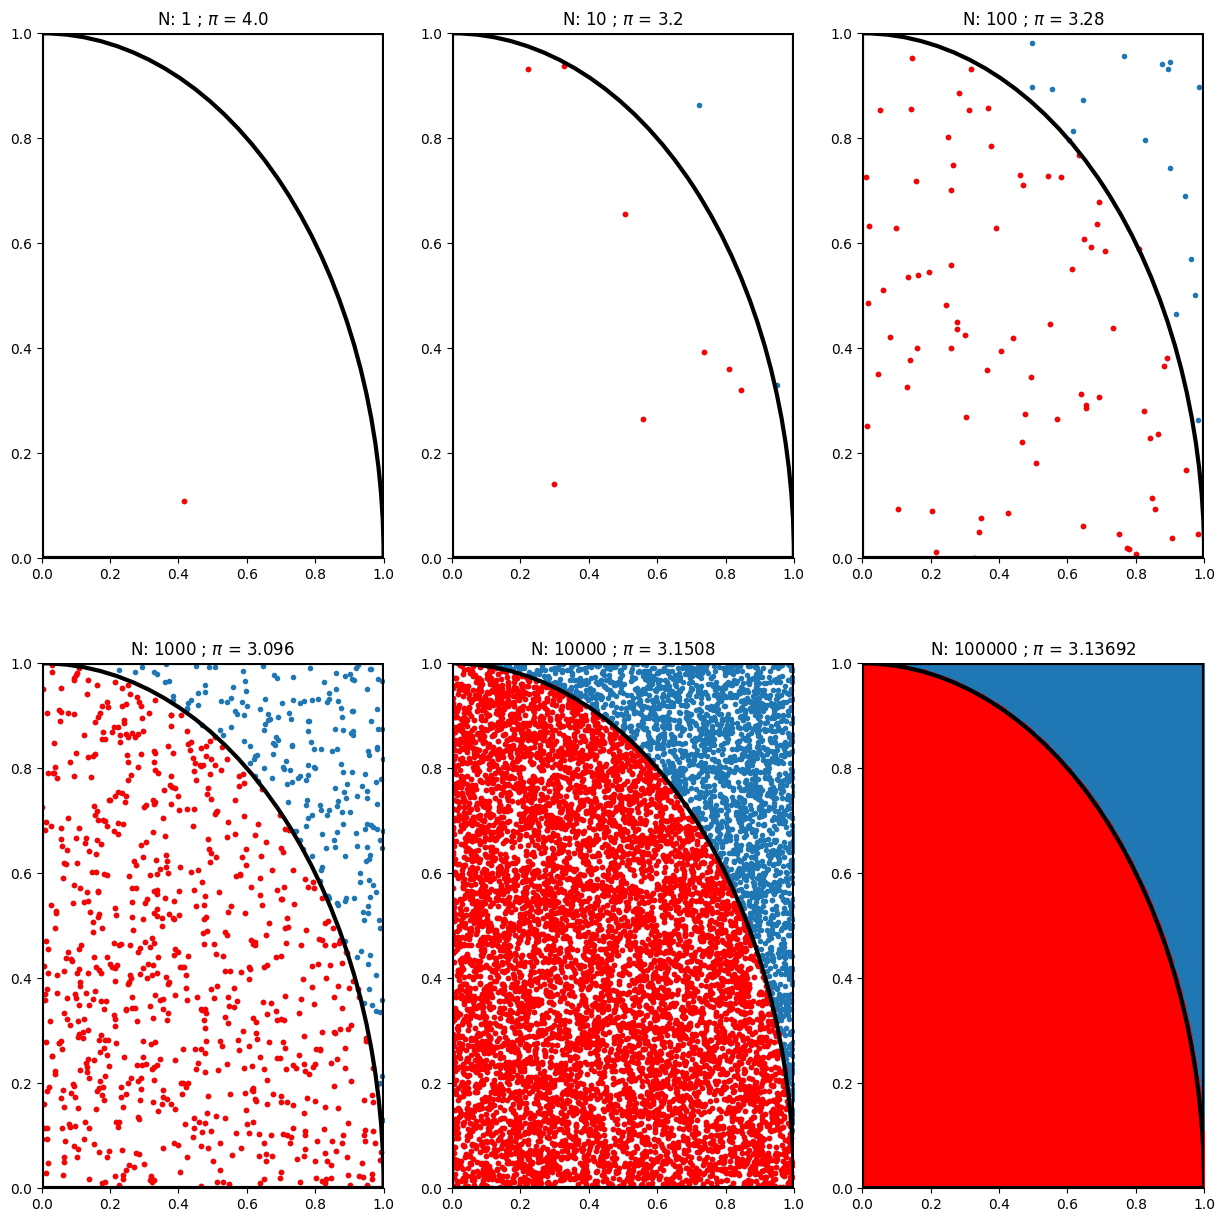

In [5]:
fig, axs = plt.subplots(2, 3, sharex=False, sharey=True, figsize=(15,15))
N = [1, 10, 100, 1000, 10000, 100000]
for i, sample_points in enumerate(N):
    if i < 3:
        j = 0
    else:
        j = 1
    mc_study.sample_points(sample_points)
    mc_study.plot_sampling(axs=axs[j, i - j*3])
plt.show()

Now we have something interesting to look at. It seems roughly that as we increase the number of sampling points, the prediction of Pi becomes close to the actual value. But let's do this with a little more rigor and plot the convergence towards Pi as a function of sample points.

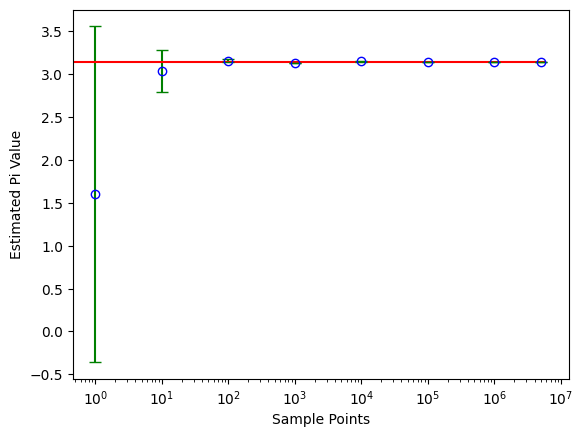

In [6]:
N = [1, 10, 100, 1000, 10000, 100000, 1000000, 5000000]
ensemble = 10
pi = []
pi_error = []

for sample_points in N:
    temp_pi = []
    for i in range(ensemble):
        mc_study.sample_points(sample_points)
        temp_pi.append(4 * mc_study.n_circle_points / mc_study.n_points)
    
    pi.append(np.mean(temp_pi))
    pi_error.append(np.std(temp_pi)/np.sqrt(sample_points))
    
plt.errorbar(N, pi, yerr=pi_error, marker='o', color='b', ecolor='g', linestyle='', mfc='None')
plt.hlines(np.pi, 0, 6000000, color='r')
plt.xscale('log')
plt.xlabel('Sample Points')
plt.ylabel('Estimated Pi Value')
plt.show()

So now we can see a little more clearly that as we increase the number of sample points in our Monte Carlo approach, we will begin to converge to the value of Pi. Another layer of accuracy that we have added here is the use of an ensemble average. What this means is that rather than simply running one Monte Carlo sampling experiment using N sample points, we run M Monte Carlo sampling experiments with N sample points. This is important not only for error prediction, which we see also converges to 0 as the number of sample points increases, but also because Monte Carlo is based upon random sampling. This means that several seeds should really be used to generate random numbers in order to *fairly* represent how accurate this number of sample points is. One might find for example, If I ran a Monte Carlo run on 22 points that I, purely by chance, predict Pi to be 3.14. On a  simple reading one might think wow 22 points is enough, but this is not a fair statement, Should I run this experiment 1000 times with 22 points and the value is also between 3.13 and 3.15, then I can argue that this is enough points to get a reasonable estimate. This ensemble approach is designed to incorporate this confidence into our result.

### Conclusions & Outlook

So in this notebook we have seen how simple Monte Carlo sampling can be used to solve for Pi in quite a geometric manner. Of course, this is not the only application of Monte Carlo and indeed, this is not even the way in which it is typically implemented. However, for this we will need a bit more time, and a more complicated notebook so we can leave this for another time.